### Updated April 2024 for C11
### Updated May 2023 for C10 with new plot

In [1]:
# Import statements
from full_spectrum_plot import plot_spectrum
from astropy.stats import mad_std
from astropy.io import fits
from spectral_cube import OneDSpectrum
from astropy import units as u
import pyspeckit
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

# Define directory we're working with
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/spectra/'

make: *** No targets specified and no makefile found.  Stop.


In [2]:
SM_SIZE = 12
MD_SIZE = 18
LG_SIZE = 22

plt.rc('font', size = MD_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = LG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = MD_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = SM_SIZE)    # legend fontsize
plt.rc('figure', titlesize = LG_SIZE)   # fontsize of the figure title

In [3]:
# Get names of spectral windows
# I think these are in vaguely the right order?
freq_spws = [
'87_spw25',
# '87_spw102', # duplicate of above
'89_spw27',
# '89_spw104', # duplicate of above

'91_spw25', 
# '91_spw102', # duplicate of above
'93_spw27',
# '93_spw104', # duplicate of above
'95_spw25', 
'97_spw27', 
'98_spw29',
# '98_spw106', # duplicate of above
# '99_spw25', # duplicate of above
'99_spw31',  
# '99_spw108', # duplicate of above

# '101_spw27', # duplicate of above
'102_spw23',
'102_spw29', 
# '102_spw106', # duplicate of above
'104_spw25', # mislabeled, should be before 103_spw31
'103_spw31', 
# '103_spw108', # duplicate of above
'106_spw29',
'107_spw31',

'110_spw29',
'111_spw31',
'112_spw27',
'114_spw29',

'127_spw65', 
'129_spw67',

'130_spw105',
'132_spw107',
'134_spw45', 
'135_spw47',
'137_spw85',
'137_spw69',
# '139_spw87', # duplicate of above
'139_spw71',
# '141_spw25', # duplicate of above

'140_spw109',
'142_spw111',
'144_spw49',
'146_spw51',
'147_spw89',
'149_spw91',

'142_spw27', # mislabeled
# '151_spw29', # duplicate of above
'152_spw31',

'244_spw65',
'245_spw67',
'247_spw105',
'249_spw107',

'250_spw25',
'252_spw27',
'254_spw85',
'255_spw87',
'257_spw45',
'259_spw47',
# '258_spw69', # significant overlap with above?
'259_spw71',

'261_spw109',
'263_spw111',
'264_spw29',
'266_spw31',
'268_spw89',

'270_spw91',
'271_spw49',
'273_spw51'
]

In [4]:
# Create list of filenames and plot spectral coverage of our spectral windows
max_fns = []
spectra = []
for i in range(len(freq_spws)):
    max_fn = results+'source_ab_'+freq_spws[i]+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.max_CROPPED.fits'
    max_fns.append(max_fn)
    sp = OneDSpectrum.from_hdu(fits.open(max_fns[i])).to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp.hdu)
#     sp.baseline()
    sp.data -= np.median(sp.data)
#     sp.plotter()
    spectra.append(sp)
#     print(i,': ',freq_spws[i])
#     plot_spectrum(max_fn)

In [5]:
'''Spectrum interpolation method (maybe easier to conceptualize?)'''
# Divide total spectral space into 1 GHz bins
bin_size = 1.0e9
freq_bin_edges = np.arange(spectra[0].xarr[0].value, spectra[-1].xarr[-1].value, bin_size)
freq_bin_centers = np.arange(spectra[0].xarr[0].value + 0.5*bin_size, 
                             spectra[-1].xarr[-1].value - 0.5*bin_size, bin_size)

step_size = spectra[0].xarr[1] - spectra[0].xarr[0] # get step size from spectrum

binned_spectra = [] # Collect spectrum for each bin
sigmas = [] # Collect sigma values for each bin
fractions = [] # Collect fractions of bin bandwidth that are above 7 sigma
# Loop over each bin
for edge_i in range(len(freq_bin_centers)): 
    ll, ul = freq_bin_edges[edge_i]*u.Hz, freq_bin_edges[edge_i+1]*u.Hz # I had this as GHz oops
    
    overlapping_spws = [] # Collect indices of spws that overlap with bin
    # Loop over each spectral window
    for spectrum_i in range(len(spectra)):
        # Check for overlap between the bin and the spectral window
        ll_in_spw = spectra[spectrum_i].xarr.in_range(ll)
        ul_in_spw = spectra[spectrum_i].xarr.in_range(ul)
#         print("Bin limits:", ll.to(u.GHz), ul.to(u.GHz))
#         print("Spectral window limits:", spectra[spectrum_i].xarr[0].to(u.GHz),
#              spectra[spectrum_i].xarr[-1].to(u.GHz))
#         print(ll_in_spw, ul_in_spw)
        if ll_in_spw or ul_in_spw:
            overlapping_spws.append(spectrum_i)
#     print(overlapping_spws)
            
    # If there are no spws that overlap with bin, set fraction to nan so they're not plotted
    if len(overlapping_spws) == 0:
        sigma = np.nan
        frac = np.nan
        fractions.append(frac)
        sigmas.append(sigma)
    
    else:
        # Create x-axis from bin and interpolate all spectra onto that x-axis
        xarr = pyspeckit.units.SpectroscopicAxis(np.arange(ll.value, ul.value, step_size.value)*u.Hz)
        
        interp_spectra = []
        # Grab correct spectra from list of overlapping spws to interpolate over for this bin
        for spw_i in overlapping_spws:
            interp_spectrum = pyspeckit.spectrum.interpolation.interp_on_axes(spectra[spw_i], xarr)
            interp_spectra.append(interp_spectrum)

        # Average all spectra together
        if len(interp_spectra) == 1:
#             print("Single spectrum")
            spec_average = interp_spectra[0]
        if len(interp_spectra) > 1:
#             print("Averaged spectrum")
            spec_all = pyspeckit.spectrum.classes.ObsBlock(interp_spectra)
            spec_average = spec_all.average()

        # Convert all 0's in averaged spectrum to nan
        spec_average.data[spec_average.data == 0] = np.nan
        binned_spectra.append(spec_average)
            
        # Calculate MAD-estimated RMS of averaged spectrum
        sigma = mad_std(spec_average.data, ignore_nan = True) # in K
        sigmas.append(sigma)
#         print(7.0*sigma)
        above_7_sigma_mask = spec_average.data > 7.0*sigma

        # Calculate fraction of averaged spectrum above 7*sigma
        frac = np.count_nonzero(above_7_sigma_mask)/len(above_7_sigma_mask) # frac in mask
        fractions.append(frac)

In [6]:
# plt.figure(figsize=(9, 5))
# plt.plot(freq_bin_centers*(1/(10.**9)), freq_bin_centers/freq_bin_centers, marker=',')
# plt.xlabel('Center frequency (GHz)')
# plt.ylabel('Arbitrary 1')
# plt.title('Bin centers')
# plt.show()

Center (GHz): 115.05157773300688
Sigma: 0.10727125471117814
7*sigma 0.750898782978247
Fraction above 7*sigma: 0.08195121951219513


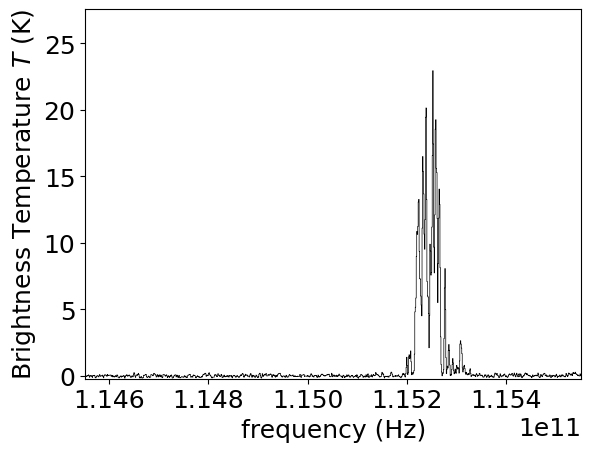

In [7]:
ind = 29
print("Center (GHz):",freq_bin_centers[ind]*(1/(10.**9)))
print("Sigma:",sigmas[ind])
print("7*sigma",7*sigmas[ind])
print("Fraction above 7*sigma:",fractions[ind])

sp_ind = binned_spectra[ind]
sp_ind.plotter()

In [8]:
mpatches.Rectangle?

Object `mpatches.Rectangle` not found.


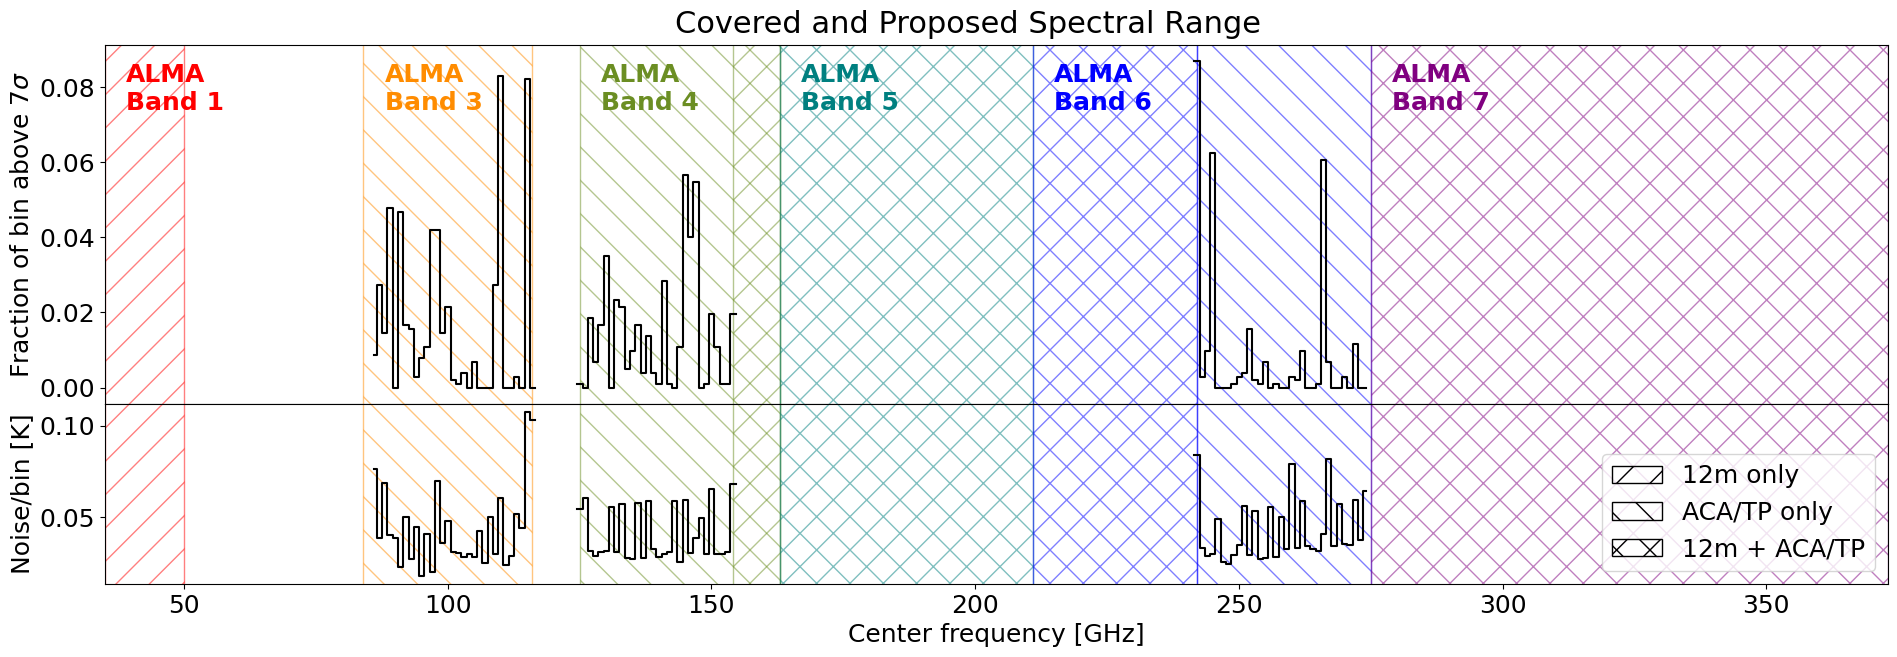

In [16]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize = (23, 7)) # 23, 7 for ALMA proposal
gs = fig.add_gridspec(2, hspace = 0, height_ratios = [2, 1])
axs = gs.subplots(sharex = True, sharey = False)

fig.suptitle('Covered and Proposed Spectral Range', y = 0.93)

axs[0].plot(freq_bin_centers*(1/(10.**9)), fractions, linestyle = '-', color = 'k', drawstyle = 'steps-mid')
axs[1].plot(freq_bin_centers*(1/(10.**9)), sigmas, linestyle = '-', color = 'k', drawstyle = 'steps-mid')

axs[1].set_xlabel('Center frequency [GHz]', fontsize = 18)
axs[0].set_ylabel('Fraction of bin above $7\sigma$', fontsize = 18)
axs[1].set_ylabel('Noise/bin [K]', fontsize = 18)

axs[1].set_xlim(35, 373)
# axs[1].set_xlim(np.min(freq_bin_centers*(1/(10.**9))), np.max(freq_bin_centers*(1/(10.**9))))
# axs[1].set_xticks(np.linspace(np.min(freq_bin_centers*(1/(10.**9))), np.max(freq_bin_centers*(1/(10.**9))), 12))

# # Hide x labels and tick labels for all but bottom plot.
# for ax in axs:
#     ax.label_outer()

# Add rectangles for receiver coverage (top plot)
band1f = mpatches.Rectangle((35, -0.02), (50. - 35.), 0.2, alpha = 0.1, facecolor = "red")
band3f = mpatches.Rectangle((84, -0.02), (116. - 84.), 0.2, alpha = 0.1, facecolor = "darkorange")
band4f = mpatches.Rectangle((125, -0.02), (163. - 125.), 0.2, alpha = 0.1, facecolor = "olivedrab")
band5f = mpatches.Rectangle((163, -0.02), (211. - 163.), 0.2, alpha = 0.1, facecolor = "teal")
band6f = mpatches.Rectangle((211, -0.02), (275. - 211.), 0.2, alpha = 0.1, facecolor = "blue")
band7f = mpatches.Rectangle((275, -0.02), (373. - 275.), 0.2, alpha = 0.1, facecolor = "purple")
# Add rectangles for receiver coverage (bottom plot)
band1n = mpatches.Rectangle((35, -0.02), (50. - 35.), 0.15, alpha = 0.1, facecolor = "red")
band3n = mpatches.Rectangle((84, -0.02), (116. - 84.), 0.15, alpha = 0.1, facecolor = "darkorange")
band4n = mpatches.Rectangle((125, -0.02), (163. - 125.), 0.15, alpha = 0.1, facecolor = "olivedrab")
band5n = mpatches.Rectangle((163, -0.02), (211. - 163.), 0.15, alpha = 0.1, facecolor = "teal")
band6n = mpatches.Rectangle((211, -0.02), (275. - 211.), 0.15, alpha = 0.1, facecolor = "blue")
band7n = mpatches.Rectangle((275, -0.02), (373. - 275.), 0.15, alpha = 0.1, facecolor = "purple")
# Plot them
# axs[0].add_patch(band1f)
# axs[0].add_patch(band3f)
# axs[0].add_patch(band4f)
# axs[0].add_patch(band5f)
# axs[0].add_patch(band6f)
# axs[0].add_patch(band7f)
# axs[1].add_patch(band1n)
# axs[1].add_patch(band3n)
# axs[1].add_patch(band4n)
# axs[1].add_patch(band5n)
# axs[1].add_patch(band6n)
# axs[1].add_patch(band7n)
# Label them
axs[0].text(35  + 4, 0.074,  'ALMA\nBand 1', fontsize = MD_SIZE, color = "red", fontweight = "bold")
axs[0].text(84  + 4, 0.074,  'ALMA\nBand 3', fontsize = MD_SIZE, color = "darkorange", fontweight = "bold")
axs[0].text(125 + 4, 0.074,  'ALMA\nBand 4', fontsize = MD_SIZE, color = "olivedrab", fontweight = "bold")
axs[0].text(163 + 4, 0.074,  'ALMA\nBand 5', fontsize = MD_SIZE, color = "teal", fontweight = "bold")
axs[0].text(211 + 4, 0.074,  'ALMA\nBand 6', fontsize = MD_SIZE, color = "blue", fontweight = "bold")
axs[0].text(275 + 4, 0.074,  'ALMA\nBand 7', fontsize = MD_SIZE, color = "purple", fontweight = "bold")

# Add patches for proposed spectral regions (top plot)
# hatch options: '/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'
band1p = mpatches.Rectangle((35, -0.02), (50. - 35.), 0.2, hatch = '/', alpha = 0.5, fill = 0, ec = "red") # Band 1 proposed: 12m + ACA
band3p = mpatches.Rectangle((84, -0.02), (116. - 84.), 0.2, hatch = '\\', alpha = 0.5, fill = 0, ec = "darkorange") # Band 3 proposed: ACA + TP
band4p = mpatches.Rectangle((125, -0.02), (163. - 125.), 0.2, hatch = '\\', alpha = 0.5, fill = 0, ec = "olivedrab") # Band 4 proposed: ACA + TP
band4p12m = mpatches.Rectangle((154, -0.02), (163. - 154.), 0.2, hatch = '/', alpha = 0.5, fill = 0, ec = "olivedrab") # Band 4 proposed: 12m (152 - 163 GHz)
band5p = mpatches.Rectangle((163, -0.02), (211. - 163.), 0.2, hatch = 'x', alpha = 0.5, fill = 0, ec = "teal") # Band 5 proposed: 12m + ACA + some TP
band6p = mpatches.Rectangle((211, -0.02), (242. - 211.), 0.2, hatch = 'x', alpha = 0.5, fill = 0, ec = "blue") # Band 6 proposed: 12m + ACA (211 - 242 GHz)
band6pACA = mpatches.Rectangle((242, -0.02), (275. - 242.), 0.2, hatch = '\\', alpha = 0.5, fill = 0, ec = "blue") # Band 6 proposed: ACA + TP (242 - 275 GHz)
band7p = mpatches.Rectangle((275, -0.02), (373. - 275.), 0.2, hatch = 'x', alpha = 0.5, fill = 0, ec = "purple") # Band 7 proposed: 12m + ACA + TP
# Add patches for proposed spectral regions (bottom plot)
# hatch options: '/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'
band1pn = mpatches.Rectangle((35, -0.02), (50. - 35.), 0.15, hatch = '/', alpha = 0.5, fill = 0, ec = "red") # Band 1 proposed: 12m + ACA
band3pn = mpatches.Rectangle((84, -0.02), (116. - 84.), 0.15, hatch = '\\', alpha = 0.5, fill = 0, ec = "darkorange") # Band 3 proposed: ACA + TP
band4pn = mpatches.Rectangle((125, -0.02), (163. - 125.), 0.15, hatch = '\\', alpha = 0.5, fill = 0, ec = "olivedrab") # Band 4 proposed: ACA + TP
band4pn12m = mpatches.Rectangle((154, -0.02), (163. - 154.), 0.15, hatch = '/', alpha = 0.5, fill = 0, ec = "olivedrab") # Band 4 proposed: 12m (152 - 163 GHz)
band5pn = mpatches.Rectangle((163, -0.02), (211. - 163.), 0.15, hatch = 'x', alpha = 0.5, fill = 0, ec = "teal") # Band 5 proposed: 12m + ACA + some TP
band6pn = mpatches.Rectangle((211, -0.02), (242. - 211.), 0.15, hatch = 'x', alpha = 0.5, fill = 0, ec = "blue") # Band 6 proposed: 12m + ACA (211 - 242 GHz)
band6pnACA = mpatches.Rectangle((242, -0.02), (275. - 242.), 0.15, hatch = '\\', alpha = 0.5, fill = 0, ec = "blue") # Band 6 proposed: ACA + TP (242 - 275 GHz)
band7pn = mpatches.Rectangle((275, -0.02), (373. - 275.), 0.15, hatch = 'x', alpha = 0.5, fill = 0, ec = "purple") # Band 7 proposed: 12m + ACA + TP
# Plot them
axs[0].add_patch(band1p)
axs[0].add_patch(band3p)
axs[0].add_patch(band4p)
axs[0].add_patch(band4p12m)
axs[0].add_patch(band5p)
axs[0].add_patch(band6p)
axs[0].add_patch(band6pACA)
axs[0].add_patch(band7p)
axs[1].add_patch(band1pn)
axs[1].add_patch(band3pn)
axs[1].add_patch(band4pn)
axs[1].add_patch(band4pn12m)
axs[1].add_patch(band5pn)
axs[1].add_patch(band6pn)
axs[1].add_patch(band6pnACA)
axs[1].add_patch(band7pn)

# Make a DIY legend
code_artists = [mpatches.Rectangle([0, 0], 0, 0, fill = 0, hatch = '/', color='k'),
                mpatches.Rectangle([0, 0], 0, 0, fill = 0, hatch = '\\', color='k'), 
                mpatches.Rectangle([0, 0], 0, 0, fill = 0, hatch = 'x', color='k')]
code_labels = ["12m only", "ACA/TP only", "12m + ACA/TP"]
axs[1].legend(handles = code_artists, labels = code_labels, loc="lower right", fontsize = 18)

plt.rcParams.update({
    "figure.facecolor":  'none',
    "axes.facecolor":    'w',
    "savefig.facecolor": 'none'
})

plt.savefig('/blue/adamginsburg/abulatek/brick/first_results/figures/line_density_proposal.pdf', facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight')
plt.savefig('/blue/adamginsburg/abulatek/brick/first_results/figures/line_density_proposal.png', dpi = 250, bbox_inches = 'tight')
plt.show()

### Sensitivity in each spectral window

In [10]:
# Get filenames of self-smoothed cubes
import glob
cube_fns = glob.glob('/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/*.commonbeam.fits')

In [11]:
# Import all self-smoothed cubes
from spectral_cube import SpectralCube

smoothed_cubes = []
for cube_fn in cube_fns:
    smoothed_cube = SpectralCube.read(cube_fn, use_dask = True)
    smoothed_cubes.append(smoothed_cube)

In [12]:
# Calculate common beam between all cubes
import radio_beam

beams = []
for cube in smoothed_cubes:
    beams.append(cube.beam)

common_beam = radio_beam.commonbeam.common_manybeams_mve(radio_beam.Beams(beams = beams)) # Get common beam between all cubes
common_beam

Beam: BMAJ=1.7218346709877002 arcsec BMIN=1.4001623726948096 arcsec BPA=96.46705640155062 deg

In [13]:
# Smooth all cubes to a common beam
resampled_cubes = []
for cube in smoothed_cubes:
    resampled_cube = cube.convolve_to(common_beam) # This cell takes almost no time; the cubes do not get convolved in this step
    resampled_cubes.append(resampled_cube)

In [14]:
# For parallelization, which helps to make convolution faster
import dask
dask.config.set(scheduler = 'threads', num_workers = 8)
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [15]:
# # Calculate sensitivity in a common beam, takes a long time (>20 mins)
# from astropy.stats import mad_std

# rms_values = []
# for cube in resampled_cubes:
#     rms_array = cube.mad_std(axis = (1, 2)) # do axis = (1, 2) to do per-channel calc., then median of resulting array
#     rms = np.median(rms_array)
#     rms_values.append(rms)
#     break # For now, just do this once